In [22]:
import torch
import os
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO
import pyro.distributions as dist

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

os.chdir('/Users/lucreziavaleriani/Documents/GitHub/LOCATE/')

from simulations.simulations import simulate_segment, simulate_data

In [23]:
purity = 1
coverage = 100
ploidy = 2

segs = simulate_segment(only_clonal = True, purity = purity, coverage = coverage, genome_size = 30000000)
snp,snv = simulate_data(segs)

snv = snv.loc[snv['vaf'] < 1]
take_idx = snv.index
snp = snp[snp.index.isin(take_idx)]


data_input = {'baf':torch.tensor(np.array(snp['baf']).reshape(-1, 1)), 
              'dr':torch.tensor(np.array(snp['dr']).reshape(-1, 1)),
              'vaf':torch.tensor(np.array(snv['nv']).reshape(-1, 1)),
              'dp':torch.tensor(np.array(snv['coverage']).reshape(-1, 1)),
              'dp_snp':torch.tensor(np.array(snp['cov']).reshape(-1, 1))}
cns = snp.CN_1
print(snp.shape)

(1831, 9)


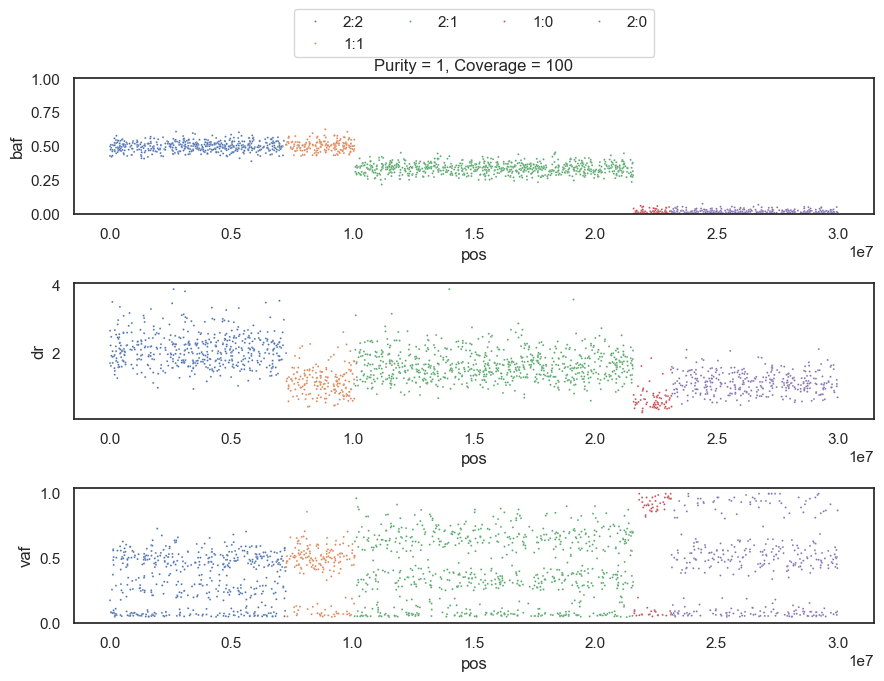

In [24]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(3, 1, figsize=(9, 7))

baf = sns.scatterplot(data=snp, x="pos", y="baf", s=2, ax=axes[0], hue="CN_1")
dr = sns.scatterplot(data=snp, x="pos", y="dr", s=2, ax=axes[1], hue="CN_1", legend=False)
vaf = sns.scatterplot(data=snv, x="pos", y="vaf", s=2, ax=axes[2], hue="CN_1", legend=False)

axes[0].set_ylim(0,1) 
sns.move_legend(
    baf, 
    "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=4, title=None, frameon=True,
)

axes[0].set_title(f'Purity = {purity}, Coverage = {coverage}')
fig.tight_layout()

In [84]:
Major = 2
minor = 1
tot = Major+minor
cn = str(Major) + ':' + str(minor)

tmp_snv = snv.loc[snv.CN_1 == cn]
vaf = torch.tensor(np.array(tmp_snv['nv']).reshape(-1, 1))
dp = torch.tensor(np.array(tmp_snv['coverage']).reshape(-1, 1))
print(tmp_snv)

      segID       pos    nv  coverage       vaf CN_1 CN_2 ccf  purity  \
658       2  17681774  31.0       102  0.303922  2:1                1   
659       2  19431826  73.0        89  0.820225  2:1                1   
661       2  10645105  37.0        99  0.373737  2:1                1   
662       2  21075880  40.0       111  0.360360  2:1                1   
663       2  14412223  33.0        87  0.379310  2:1                1   
...     ...       ...   ...       ...       ...  ...  ...  ..     ...   
1410      2  16534452   8.0       113  0.070796  2:1                1   
1411      2  10756927   6.0       115  0.052174  2:1                1   
1412      2  13716027   8.0        99  0.080808  2:1                1   
1413      2  21054980   5.0       106  0.047170  2:1                1   
1414      2  20312263   6.0       105  0.057143  2:1                1   

                                    true_peaks   model  
658   [0.3333333333333333, 0.6666666666666666]  clonal  
659   [0.

In [85]:
def get_clonal_peaks(tot, Major, minor, purity):
    mult = []
    for i,v in enumerate(Major):
        m = []
        if torch.equal(Major[i], minor[i]):
            m.append(Major[i][0])
        else:
            if minor[i] != 0:
                m.append(Major[i][0])
                m.append(minor[i][0])
            else:
                m.append(Major[i][0])
        if torch.equal(Major[i], torch.tensor([2])) and torch.equal(minor[i], torch.tensor([1])) == False:
            m.append(torch.tensor(1))
        mult.append(m)

    clonal_peaks = []
    for i,c in enumerate(mult):
        p = []
        for m in c:
            cp = m * purity / (tot[i] * purity + 2 * (1 - purity))
            p.append(cp)
        clonal_peaks.append(p)
        
    return clonal_peaks


In [86]:
x = torch.tensor([[0],
        [1],
        [2],
        [3],
        [4]]) 
tot = torch.tensor([1, 2, 2, 3, 4]) 
Major = torch.tensor([1, 2, 1, 2, 2]) 
minor = torch.tensor([0, 0, 1, 1, 2])

In [87]:
clonal_peaks = get_clonal_peaks(tot[x], Major[x], minor[x], purity)

In [88]:
clonal_peaks

[[tensor([1.])],
 [tensor([1.]), tensor([0.5000])],
 [tensor([0.5000])],
 [tensor([0.6667]), tensor([0.3333])],
 [tensor([0.5000]), tensor([0.2500])]]

In [90]:
dp = dp.unsqueeze(dim=2)
vaf = vaf.unsqueeze(dim=2)


In [91]:
tmp_vaf_lk = []
for cn in clonal_peaks:
        tmp_peak = 0.0
        for p in cn:
                bin_lk = dist.Binomial(total_count = dp, 
                                                probs = p,
                                        ).log_prob(vaf)
                tmp_peak+= (1/len(cn)) * bin_lk
        print(tmp_peak.shape)
        tmp_vaf_lk.append(tmp_peak)

torch.Size([756, 1, 1])
torch.Size([756, 1, 1])
torch.Size([756, 1, 1])
torch.Size([756, 1, 1])
torch.Size([756, 1, 1])


In [93]:
len(tmp_vaf_lk)

5

In [95]:
torch.cat(tmp_vaf_lk, dim=1).shape

torch.Size([756, 5, 1])